In [1]:
!wget https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip
!unzip QQP-clean.zip

--2022-11-27 10:49:24--  https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41696084 (40M) [application/zip]
Saving to: ‘QQP-clean.zip’

QQP-clean.zip       100%[===================>]  39.76M  28.1MB/s    in 1.4s    

2022-11-27 10:49:26 (28.1 MB/s) - ‘QQP-clean.zip’ saved [41696084/41696084]

Archive:  QQP-clean.zip
   creating: QQP/
  inflating: QQP/train.tsv           
  inflating: QQP/dev.tsv             
  inflating: QQP/test.tsv            


In [2]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.0 MB/s 
     |████████████████████████████████| 5.5 MB 47.8 MB/s 
     |████████████████████████████████| 1.3 MB 24.5 MB/s 
     |████████████████████████████████| 182 kB 13.0 MB/s 
     |████████████████████████████████| 7.6 MB 17.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7fd6f75fd3e23987b7bdbca68917dfc825e743efd371b029951fe2b0e26ae1ce
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import random, os
import numpy as np
import pandas as pd
from pprint import pprint

from sentence_transformers import SentenceTransformer, util
from torchinfo import summary

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed_everything()    

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [7]:
TRAIN_PATH = "QQP/train.tsv"
VAL_PATH = "QQP/dev.tsv"
TEST_PATH = "QQP/test.tsv"

In [8]:
train_df = pd.read_csv(TRAIN_PATH, delimiter="\t")
val_df = pd.read_csv(VAL_PATH, delimiter="\t")
test_df = pd.read_csv(TEST_PATH, delimiter="\t")

In [9]:
pprint (train_df.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [10]:
print (train_df.isnull().sum())
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [11]:
N_samples = "FULL" # "FULL" or some integer

if N_samples == "FULL":
    train_corpus1 = train_df['question1'].to_list()
    train_corpus2 = train_df['question2'].to_list()
    train_labels = train_df['is_duplicate'].to_list()
else:
    assert isinstance(N_samples, int), "N_samples is not integer"

    train_corpus1 = train_df['question1'].to_list()[:N_samples]
    train_corpus2 = train_df['question2'].to_list()[:N_samples]
    train_labels = train_df['is_duplicate'].to_list()[:N_samples]

val_corpus1 = val_df['question1'].to_list()
val_corpus2 = val_df['question2'].to_list()
val_labels = val_df['is_duplicate'].to_list()

In [12]:
test_corpus1 = test_df['question1'].to_list()
test_corpus2 = test_df['question2'].to_list()
# test_labels = test_df['is_duplicate'].to_list()

QN1, QN2, Label

In [13]:
class Dataset_seq(torch.utils.data.Dataset):
    def __init__(self, questions1, questions2, labels):
        # read the data and label 
        self.qn1, self.qn2, self.labels = questions1, questions2, labels
        self.model = SentenceTransformer('all-MiniLM-L6-v2').to(torch.device("cuda:0"))
        self.emb1, self.emb2 = self.preprocess(questions1, questions2)

    def __getitem__(self, index):
        # return the seq and label 
        emb1 = self.emb1[index]
        emb2 = self.emb2[index]
        label = torch.tensor(self.labels[index]).float()

        return emb1, emb2, label

    def __len__(self):
        return(len(self.labels))

    def preprocess(self, corpus1, corpus2):
        # used to convert line into tokens and then into their corresponding numericals values using word2id
        embeddings1 = self.model.encode(corpus1, convert_to_tensor=True)
        embeddings2 = self.model.encode(corpus2, convert_to_tensor=True)

        N1, d1 = embeddings1.shape
        N2, d2 = embeddings2.shape

        embeddings1 = embeddings1.view(N1, 1, d1)
        embeddings2 = embeddings2.view(N2, 1, d2)

        return embeddings1, embeddings2

In [14]:
train_dataset = Dataset_seq(train_corpus1, train_corpus2, train_labels) # takes about 4-5 mins to run
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [15]:
val_dataset = Dataset_seq(val_corpus1, val_corpus2, val_labels) # takes <1 min to run
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=256)

In [16]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, proj_dim, fc_dim=256, num_layers=5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.proj_dim = proj_dim

        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.project = nn.Linear(fc_dim, proj_dim)

    def forward(self, x):
        B, T, d = x.shape
        h_0 = torch.autograd.Variable(torch.zeros(self.num_layers, B, self.hidden_dim)).to(x.device) # hidden state
        c_0 = torch.autograd.Variable(torch.zeros(self.num_layers, B, self.hidden_dim)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm forward pass
        hn = hn.mean(0).view(-1, self.hidden_dim) # average across layer dimension
        
        out = torch.relu(hn)
        out = self.fc1(out) #first Dense
        out = torch.relu(out) #relu
        out = self.project(out) #Final Output

        return out

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, lstm_hidden_dim, proj_dim, h1=128, h2=64, out_dim=1):
        super().__init__()
        self.lstm = LSTM(in_dim, lstm_hidden_dim, proj_dim)

        self.net = nn.Sequential(
                        nn.Linear(2 * proj_dim, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, out_dim),
                        nn.Sigmoid()
                    )

    def forward(self, x1, x2, add_ftrs=None, contrastive=False):
        # B, T, d = x.shape
        hn1 = self.lstm(x1)
        hn2 = self.lstm(x2)
        
        x_cat = torch.cat([hn1, hn2], dim=1)
        assert x_cat.size(1) == hn1.size(1) * 2 == hn2.size(1) * 2
        
        x_cat = torch.relu(x_cat)
        out = self.net(x_cat)

        if contrastive:
            return out, hn1, hn2

        return out

In [21]:
def get_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    # return (y_true == y_prob).sum().item() / y_true.size(0)
    return (y_true == y_prob).sum().item()

def evaluate_model(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            q1, q2, y = data
            q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
            q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
            
            outputs = model(q1, q2)
            outputs = outputs.view(-1)
            y = y.view(-1)

            batch_acc = get_accuracy(y, outputs)
            batch_size = y.size(0)

            correct += batch_acc
            total += batch_size

    return correct / total

In [22]:
# instantiate model
model = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))
optimiser = torch.optim.AdamW(model.parameters())
sl_loss_fn = nn.BCELoss()

# training loop
EPOCHS = 50

sl_losses = []
sl_accs_train = []
sl_accs_test = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for b_idx, batch in enumerate(train_loader):
        optimiser.zero_grad()
        
        q1, q2, y = batch
        q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
        q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
        
        pred = model(q1, q2)
        loss = sl_loss_fn(pred.view(-1), y)
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.detach().item()

    epoch_loss = epoch_loss / len(train_loader)
    sl_losses.append(epoch_loss)

    model.eval()
    train_accuracy = evaluate_model(model, train_loader)
    test_accuracy = evaluate_model(model, val_loader)

    sl_accs_train.append(train_accuracy)
    sl_accs_test.append(test_accuracy)

    if epoch % 5 == 0:
        print (f"Epoch loss: {epoch_loss:.10f} | Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {test_accuracy:.4f}")

Epoch loss: 0.5327619906 | Train Accuracy: 0.7452 | Val Accuracy: 0.7432
Epoch loss: 0.3778854727 | Train Accuracy: 0.8418 | Val Accuracy: 0.8210
Epoch loss: 0.2948914302 | Train Accuracy: 0.8865 | Val Accuracy: 0.8355
Epoch loss: 0.2254990719 | Train Accuracy: 0.9230 | Val Accuracy: 0.8419
Epoch loss: 0.1681908817 | Train Accuracy: 0.9506 | Val Accuracy: 0.8456
Epoch loss: 0.1253005732 | Train Accuracy: 0.9652 | Val Accuracy: 0.8502
Epoch loss: 0.0961408323 | Train Accuracy: 0.9752 | Val Accuracy: 0.8464
Epoch loss: 0.0796772647 | Train Accuracy: 0.9818 | Val Accuracy: 0.8482
Epoch loss: 0.0692585837 | Train Accuracy: 0.9800 | Val Accuracy: 0.8439
Epoch loss: 0.0606845269 | Train Accuracy: 0.9852 | Val Accuracy: 0.8500


In [23]:
print ("Max Train Accuracy for LSTM-SL:", max(sl_accs_train))
print ("Max Val Accuracy for LSTM-SL:", max(sl_accs_test))

Max Train Accuracy for LSTM-SL: 0.9851503108457974
Max Val Accuracy for LSTM-SL: 0.85016077170418


In [24]:
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 26.6 MB/s 


In [25]:
from pytorch_metric_learning import losses

# Self-supervised Learning

Make the appropriate changes as shown in the Google Sheets.

In [26]:
# instantiate model
model2 = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))
optimiser2 = torch.optim.AdamW(model2.parameters())
sl_loss_fn = nn.BCELoss()
ssl_loss_fn = losses.ContrastiveLoss() # do NOT use losses.NTXentLoss()

# training loop
EPOCHS = 50

sl_ssl_losses = []
sl_loss_only = []
ssl_loss_only = []
sl_ssl_accs_train = []
sl_ssl_accs_test = []

# CHANGE THESE COEFFICIENTS ACCORDINGLY
c_sl = 1 
c_sl_ssl = 1

for epoch in range(EPOCHS):
    model2.train()
    epoch_loss = 0
    for b_idx, batch in enumerate(train_loader):
        optimiser2.zero_grad()
        
        q1, q2, y = batch
        q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
        q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
        
        pred, z1, z2 = model2(q1, q2, contrastive=True)
        z_cat = torch.cat([z1, z2], dim=1)

        sl_loss = sl_loss_fn(pred.view(-1), y)
        ssl_loss = ssl_loss_fn(z_cat, y)

        sl_loss_only.append(sl_loss.item())
        ssl_loss_only.append(ssl_loss.item())

        total_loss = c_sl*sl_loss + c_sl_ssl*ssl_loss
        
        total_loss.backward()
        optimiser2.step()

        epoch_loss += total_loss.detach().item()

    epoch_loss = epoch_loss / len(train_loader)
    sl_ssl_losses.append(epoch_loss)

    model2.eval()
    train_accuracy = evaluate_model(model2, train_loader)
    test_accuracy = evaluate_model(model2, val_loader)

    sl_ssl_accs_train.append(train_accuracy)
    sl_ssl_accs_test.append(test_accuracy)

    if epoch % 5 == 0:
        print (f"Epoch loss: {epoch_loss:.10f} | Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {test_accuracy:.4f}")

Epoch loss: 1.5602197659 | Train Accuracy: 0.7684 | Val Accuracy: 0.7655
Epoch loss: 1.3953550166 | Train Accuracy: 0.8415 | Val Accuracy: 0.8269
Epoch loss: 1.3372594884 | Train Accuracy: 0.8693 | Val Accuracy: 0.8375
Epoch loss: 1.2879408789 | Train Accuracy: 0.9001 | Val Accuracy: 0.8470
Epoch loss: 1.2456894323 | Train Accuracy: 0.9214 | Val Accuracy: 0.8515
Epoch loss: 1.2112037089 | Train Accuracy: 0.9339 | Val Accuracy: 0.8525
Epoch loss: 1.1843022508 | Train Accuracy: 0.9498 | Val Accuracy: 0.8535
Epoch loss: 1.1639499904 | Train Accuracy: 0.9580 | Val Accuracy: 0.8511
Epoch loss: 1.1479555015 | Train Accuracy: 0.9648 | Val Accuracy: 0.8540
Epoch loss: 1.1371310108 | Train Accuracy: 0.9696 | Val Accuracy: 0.8567


In [27]:
print ("Max Train Accuracy for LSTM-SL+SSL:", max(sl_ssl_accs_train))
print ("Max Val Accuracy for LSTM-SL+SSL:", max(sl_ssl_accs_test))

Max Train Accuracy for LSTM-SL+SSL: 0.9732414263177278
Max Val Accuracy for LSTM-SL+SSL: 0.8571357902547613


In [28]:
print (len(sl_loss_only), len(ssl_loss_only))

71100 71100


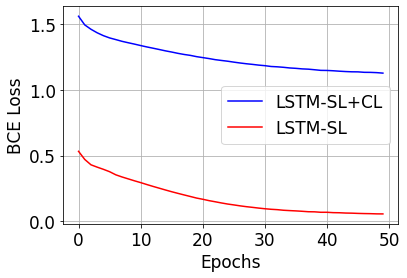

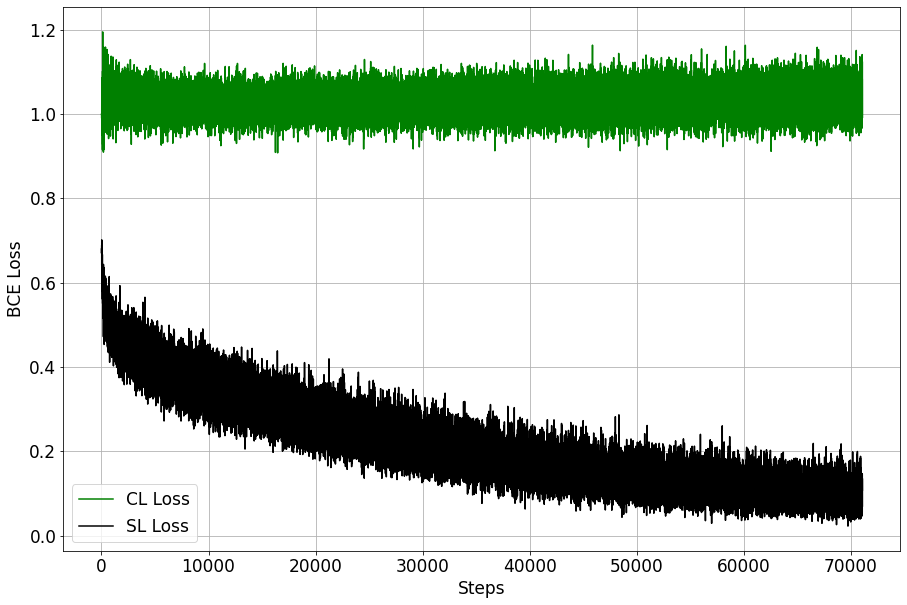

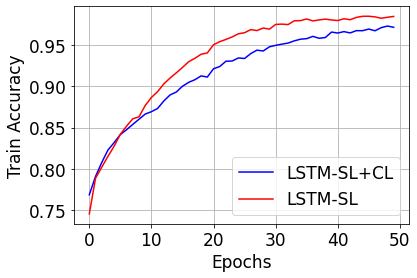

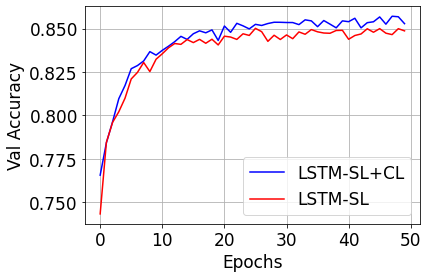

In [55]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rc('legend', **{"loc": "upper right"})

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_losses, label="LSTM-SL+CL", color="blue")
plt.plot(epochs, sl_losses, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS * len(train_loader))
fig = plt.figure(figsize=(15, 10))
plt.plot(epochs, ssl_loss_only, label="CL Loss", color="green")
plt.plot(epochs, sl_loss_only, label="SL Loss", color="black")
plt.xlabel("Steps")
plt.ylabel("BCE Loss")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_accs_train, label="LSTM-SL+CL", color="blue")
plt.plot(epochs, sl_accs_train, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_accs_test, label="LSTM-SL+CL", color="blue")
plt.plot(epochs, sl_accs_test, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.grid()
plt.legend()
plt.show()

# Macro Analysis: Centralised Kernel Alignment

In [30]:
!pip install torch_cka torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import mnist

import random, os
import numpy as np
import pandas as pd
from pprint import pprint
from torchinfo import summary
from torch_cka import CKA

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [33]:
class Dataset_CKA(torch.utils.data.Dataset):
    def __init__(self, questions1, questions2, labels):
        # read the data and label 
        self.qn1, self.qn2, self.labels = questions1, questions2, labels
        self.model = SentenceTransformer('all-MiniLM-L6-v2').to(torch.device("cuda:0"))
        self.emb1, self.emb2 = self.preprocess(questions1, questions2)

    def __getitem__(self, index):
        # return the seq and label 
        emb1 = self.emb1[index]
        emb2 = self.emb2[index]
        label = torch.tensor(self.labels[index]).float()
        combined = torch.concat([emb1, emb2], dim=1)

        return combined, label

    def __len__(self):
        return(len(self.labels))

    def preprocess(self, corpus1, corpus2):
        # used to convert line into tokens and then into their corresponding numericals values using word2id
        embeddings1 = self.model.encode(corpus1, convert_to_tensor=True)
        embeddings2 = self.model.encode(corpus2, convert_to_tensor=True)

        N1, d1 = embeddings1.shape
        N2, d2 = embeddings2.shape

        embeddings1 = embeddings1.view(N1, 1, d1)
        embeddings2 = embeddings2.view(N2, 1, d2)

        return embeddings1, embeddings2

In [34]:
cka_val_dataset = Dataset_CKA(val_corpus1, val_corpus2, val_labels) # takes <1 min to run
cka_val_loader = torch.utils.data.DataLoader(dataset=cka_val_dataset, batch_size=256)

In [35]:
cka_test_batch = next(iter(cka_val_loader))
x, y = cka_test_batch
print (x.shape)

torch.Size([256, 1, 768])


In [36]:
class CKA_LSTMClassifier(nn.Module):
    def __init__(self, in_dim, lstm_hidden_dim, proj_dim, h1=128, h2=64, out_dim=1):
        super().__init__()
        self.lstm = LSTM(in_dim, lstm_hidden_dim, proj_dim)

        # self.net = nn.Sequential(
        #                 nn.Linear(2 * proj_dim, h1),
        #                 nn.ReLU(),
        #                 nn.Linear(h1, h2),
        #                 nn.ReLU(),
        #                 nn.Linear(h2, out_dim)
        #             )
        
        self.l1 = nn.Linear(2 * proj_dim, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, out_dim)

    def forward(self, x, add_ftrs=None, contrastive=False):
        x = x.squeeze(1)
        x1, x2 = torch.split(x, x.size(1)//2, dim=1)
        x1 = x1.unsqueeze(1)
        x2 = x2.unsqueeze(1)
        
        # B, T, d = x.shape
        hn1 = self.lstm(x1)
        hn2 = self.lstm(x2)
        
        x_cat = torch.cat([hn1, hn2], dim=1)
        assert x_cat.size(1) == hn1.size(1) * 2 == hn2.size(1) * 2
        
        x_cat = torch.relu(x_cat)
        # out = self.net(x_cat)

        x = self.l1(x_cat)
        h0 = torch.relu(x)
        x = self.l2(h0)
        h1 = torch.relu(x)
        out = torch.sigmoid(self.l3(h1))

        if contrastive:
            return out, [hn1, hn2, h0, h1]

        return out

In [37]:
import copy

def alter_state_dict_keys(app):
    mapper = {
        "net.0.weight": "l1.weight",
        "net.0.bias": "l1.bias",
        "net.2.weight": "l2.weight",
        "net.2.bias": "l2.bias",
        "net.4.weight": "l3.weight",
        "net.4.bias": "l3.bias",
    }

    orig_sd = copy.deepcopy(app.state_dict())
    # new_df = base.state_dict()

    for okey, nkey in mapper.items():
        orig_sd[nkey] = orig_sd[okey]
        del orig_sd[okey]

    return orig_sd

# new_model1_sd = alter_state_dict_keys(model)
# new_model2_sd = alter_state_dict_keys(model2)

# for key, val in new_model1_sd.items():
    # print (key, val.shape)

In [38]:
cka_model1 = CKA_LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128)
cka_model2 = CKA_LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128)

new_model1_sd = alter_state_dict_keys(model)
new_model2_sd = alter_state_dict_keys(model2)

cka_model1.load_state_dict(new_model1_sd)
cka_model2.load_state_dict(new_model2_sd)

cka_model1 = cka_model1.to(torch.device("cuda:0"))
cka_model2 = cka_model2.to(torch.device("cuda:0"))

In [39]:
cka_test_batch = next(iter(cka_val_loader))
x, y = cka_test_batch
print (x.shape)

pred1 = cka_model1(x)
print (pred1.shape)

torch.Size([256, 1, 768])
torch.Size([256, 1])


In [40]:
class CudaCKA(object):
    def __init__(self, device):
        self.device = device
    
    def centering(self, K):
        n = K.shape[0]
        unit = torch.ones([n, n], device=self.device)
        I = torch.eye(n, device=self.device)
        H = I - unit / n
        return torch.matmul(torch.matmul(H, K), H)  

    def rbf(self, X, sigma=None):
        GX = torch.matmul(X, X.T)
        KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
        if sigma is None:
            mdist = torch.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = torch.exp(KX)
        return KX

    def kernel_HSIC(self, X, Y, sigma):
        return torch.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = torch.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = torch.sqrt(self.kernel_HSIC(Y, Y, sigma))
        return hsic / (var1 * var2)

In [41]:
def get_cka_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    # return (y_true == y_prob).sum().item() / y_true.size(0)
    return (y_true == y_prob).sum().item()

def evaluate_cka_model(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            q, y = data
            q, y = q.to(torch.device("cpu")), y.to(torch.device("cpu"))
            q, y = q.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
            
            outputs = model(q)
            outputs = outputs.view(-1)
            y = y.view(-1)

            batch_acc = get_accuracy(y, outputs)
            batch_size = y.size(0)

            correct += batch_acc
            total += batch_size

    return correct / total

In [42]:
cka_test_batch = next(iter(cka_val_loader))
x, y = cka_test_batch

out1, layer_reps1 = cka_model1(x, contrastive=True)
out2, layer_reps2 = cka_model2(x, contrastive=True)

In [43]:
acc1 = evaluate_cka_model(cka_model1, cka_val_loader)
acc2 = evaluate_cka_model(cka_model2, cka_val_loader)

print (acc1)
print (acc2)

0.8487014593123918
0.852856789512738


In [44]:
cuda_cka = CudaCKA(device)

In [45]:
import math

hn11, hn12 = layer_reps1[0], layer_reps1[1]
h13, h14 = layer_reps1[2], layer_reps1[3]
hn21, hn22 = layer_reps2[0], layer_reps2[1]
h23, h24 = layer_reps2[2], layer_reps2[3]

all_layers_1 = [
    torch.concat([hn11, hn12]),
    h13,
    h14,
    out1
]

all_layers_2 = [
    torch.concat([hn21, hn22]),
    h23,
    h24,
    out2
]

# print ("kernel pre-net:", cuda_cka.kernel_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item())
# print ("linear pre-net:", cuda_cka.linear_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item())
# print ("linear layer 1:")

# layer11_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item()
# layer22_score = cuda_cka.linear_CKA(h13, h23).item()
# layer33_score = cuda_cka.linear_CKA(h14, h24).item()
# layer44_score = cuda_cka.linear_CKA(out1, out2).item()

# layer12_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item()
# layer13_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), h23).item()
# layer14_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), h24).item()

# # layer11_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item()
# layer21_score = cuda_cka.linear_CKA(h13, torch.concat([hn21, hn22])).item()
# layer32_score = cuda_cka.linear_CKA(h14, h24).item()
# layer43_score = cuda_cka.linear_CKA(out1, out2).item()

# layer11_score = cuda_cka.linear_CKA(torch.concat([hn11, hn12]), torch.concat([hn21, hn22])).item()
# layer22_score = cuda_cka.linear_CKA(h13, h23).item()
# layer33_score = cuda_cka.linear_CKA(h14, h24).item()
# layer44_score = cuda_cka.linear_CKA(out1, out2).item()

"""
kernel: 0.29127955436706543
linear: 0.26045653223991394
"""        

cka_matrix = []
for l1i, l1 in enumerate(all_layers_1):
    temp = []
    for l2i, l2 in enumerate(all_layers_2):
        if l1i == l2i:
            score = cuda_cka.linear_CKA(l1, l2)
            temp.append(score.item())
        else:
            temp.append(0)
    cka_matrix.append(temp)

print (cka_matrix)

[[0.2108556628227234, 0, 0, 0], [0, 0.13758252561092377, 0, 0], [0, 0, 0.23146963119506836, 0], [0, 0, 0, 0.5034902691841125]]


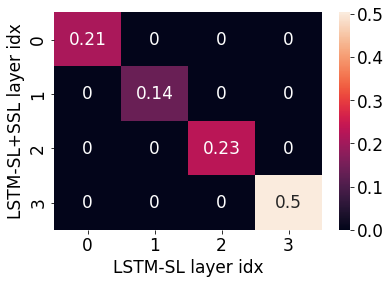

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cka_matrix, annot=True)
ax.set(xlabel="LSTM-SL layer idx", ylabel="LSTM-SL+SSL layer idx")
# plt.pcolormesh(cka_matrix, cmap="summer")
# plt.xlabel()
# plt.ylabel(results['model2_name'])
plt.show()

# Confusion Matrix Analysis

In [63]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

model = model.to(torch.device("cpu"))
model2 = model2.to(torch.device("cpu"))

def get_confusion_matrix(network, test_data_loader):
    prediction = []
    actual = []

    # iterate over test data
    for i, batch in enumerate(test_data_loader):
        q1, q2, labels = batch
        q1, q2, labels = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), labels.to(torch.device("cpu")).view(-1)

        output = network(q1, q2)
        output = torch.sigmoid(output).view(-1) > 0.5
        output = output.detach().numpy().tolist()
        prediction.extend(output)

        labels = labels.tolist()
        actual.extend(labels)

    # labels = list(set(actual))
    # labels.sort()

    cf_matrix = confusion_matrix(actual, prediction)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot()
    plt.show()

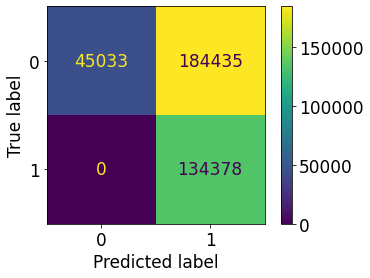

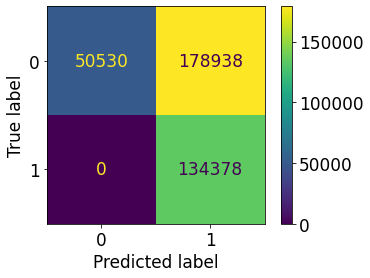

In [64]:
get_confusion_matrix(model, train_loader)
get_confusion_matrix(model2, train_loader)

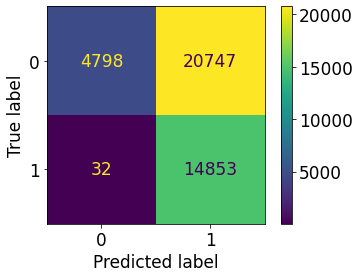

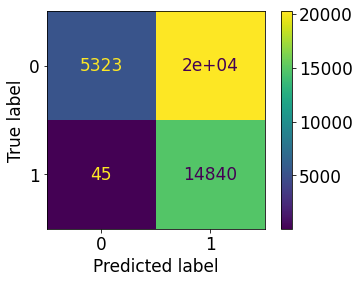

In [65]:
get_confusion_matrix(model, val_loader)
get_confusion_matrix(model2, val_loader)

Our CKA scores are pretty low ($< 0.5$). This means our models are clearly learning different things from the same dataset. But what exactly are they looking out for, and how does that correspond to the SL+SSL outperforming the pure SL model?

# Micro Analysis: What does SLL look out for?

Here, we examine a few samples that the SL+SSL model predicted correctly but the SL model predicted incorrectly. 

In [47]:
class Dataset_Micronalysis(torch.utils.data.Dataset):
    def __init__(self, questions1, questions2, labels):
        # read the data and label 
        self.qn1, self.qn2, self.labels = questions1, questions2, labels
        self.model = SentenceTransformer('all-MiniLM-L6-v2').to(torch.device("cuda:0"))
        self.emb1, self.emb2 = self.preprocess(questions1, questions2)

    def __getitem__(self, index):
        # return the seq and label 
        emb1 = self.emb1[index]
        emb2 = self.emb2[index]
        q1 = self.qn1[index]
        q2 = self.qn2[index]
        label = torch.tensor(self.labels[index]).float()

        return emb1, emb2, label, q1, q2

    def __len__(self):
        return(len(self.labels))

    def preprocess(self, corpus1, corpus2):
        # used to convert line into tokens and then into their corresponding numericals values using word2id
        embeddings1 = self.model.encode(corpus1, convert_to_tensor=True)
        embeddings2 = self.model.encode(corpus2, convert_to_tensor=True)

        N1, d1 = embeddings1.shape
        N2, d2 = embeddings2.shape

        embeddings1 = embeddings1.view(N1, 1, d1)
        embeddings2 = embeddings2.view(N2, 1, d2)

        return embeddings1, embeddings2

In [48]:
micro_val_dataset = Dataset_Micronalysis(val_corpus1, val_corpus2, val_labels) # takes <1 min to run
micro_val_loader = torch.utils.data.DataLoader(dataset=micro_val_dataset, batch_size=256)

In [49]:
lstm_sl = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))
lstm_sl_ssl = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))

lstm_sl.load_state_dict(model.state_dict())
lstm_sl_ssl.load_state_dict(model2.state_dict())

<All keys matched successfully>

In [50]:
val_batch = next(iter(micro_val_loader))
x1, x2, y, q1, q2 = val_batch

misclassified_idx = []
for i in range(y.size(0)):
    yi = y[i]
    pred1 = lstm_sl(x1, x2).view(-1)[i]
    pred2 = lstm_sl_ssl(x1, x2).view(-1)[i]

    if (pred1 > 0.5) != yi and (pred2 > 0.5) == yi:
        print (f"{i}. {q1[i]}")
        print (f"{i}. {q2[i]}")
        print (f"{i}. y={bool(yi.item())} | p1={(pred1 > 0).item()} | p2={(pred2 > 0).item()}")
        misclassified_idx.append(i)
        print ()
        print ()

print (misclassified_idx)

4. What are some good baby girl names starting with D?
4. What are some good baby girl names starting with D or H?
4. y=False | p1=True | p2=True


5. I am 25 year old guy and never had a girlfriend. Is this weird?
5. I am 25 years old. I have never had a girlfriend. Is something wrong with me?
5. y=True | p1=True | p2=True


22. Why was the Roman Empire so successful?
22. What are some of the rarely known facts about the Roman Empire?
22. y=False | p1=True | p2=True


29. Who is the Adam the lyrics to Blink-182's "Adam's Song" are written about?
29. Which Blink-182 band member wrote the lyrics to "Adam's Song"?
29. y=False | p1=True | p2=True


37. What is a good text editor?
37. What are the best text editor plugins?
37. y=False | p1=True | p2=True


59. What are the best tips for outlining/planning a novel?
59. How do I best outline my novel?
59. y=True | p1=True | p2=True


70. What is one of the biggest misconceptions people have about you?
70. What do you perceive to be the bigge

In [51]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [52]:
def POS_tagger(sent):
    return nltk.pos_tag(nltk.word_tokenize(sent))

pprint (POS_tagger(q1[i]))

[('How', 'WRB'),
 ('much', 'JJ'),
 ('does', 'VBZ'),
 ('a', 'DT'),
 ('MRI', 'NNP'),
 ('or', 'CC'),
 ('CT', 'NNP'),
 ('scan', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('head', 'NN'),
 ('cost', 'NN'),
 ('?', '.')]


In [58]:
import pandas as pd

picked_idx = [234, 86]
pos_categories = ["VB", "PRP", "NN"]

def sbert_encoder(q1, q2):
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    enc1 = encoder.encode([q1])
    enc2 = encoder.encode([q2])
    return enc1, enc2

def remove_from_sent(sent, category):
    cur_pos = POS_tagger(sent)
    n_cat = 0

    new_sentence = []
    
    for word_pair in cur_pos:
        word, wcat = word_pair
        if category not in wcat:
            new_sentence.append(word)
        else:
            n_cat += 1

    new_sentence = " ".join(new_sentence)

    return new_sentence, n_cat

def pos_logits_processor(i, pos_cats):
    n_words1 = len(q1[i].split(" "))
    n_words2 = len(q2[i].split(" "))

    op1 = lstm_sl(x1[i].unsqueeze(0), x2[i].unsqueeze(0))
    op2 = lstm_sl_ssl(x1[i].unsqueeze(0), x2[i].unsqueeze(0))

    for cat in pos_cats:
        # for each category, get the qn pairs, remove the words
        new_q1, n_cat1 = remove_from_sent(q1[i], cat)
        new_q2, n_cat2 = remove_from_sent(q2[i], cat)

        new_enc1, new_enc2 = sbert_encoder(new_q1, new_q2)
        new_enc1, new_enc2 = torch.from_numpy(new_enc1).unsqueeze(0), torch.from_numpy(new_enc2).unsqueeze(0)
        new_enc1, new_enc2 = new_enc1.to(device), new_enc2.to(device)

        p1 = lstm_sl(new_enc1, new_enc2)
        p2 = lstm_sl_ssl(new_enc1, new_enc2)

        # print (f"Current POS type: {cat} | pred: {y[i].item()}")
        # print ("Model: SL")
        # print (f"Original Logits: {op1.item():.10f} | New Logits: {p1.item():.10f}")
        # print ("Model: SL+SSL")
        # print (f"Original Logits: {op2.item():.10f} | New Logits: {p2.item():.10f}")
        # print ()        
        # print ()

        # original_log1 = [-math.log10(op1.item())]
        # new_log1 = [-math.log10(p1.item())]

        # original_log2 = [-math.log10(op2.item())]
        # new_log2 = [-math.log10(p2.item())]

        original_log1 = [op1.item()]
        new_log1 = [p1.item()]

        original_log2 = [op2.item()]
        new_log2 = [p2.item()]

        model_names1 = ["LSTM-SL"]
        model_names2 = ["LSTM-SL+CL"]

        # df = pd.DataFrame({
        #     "Original": original_log1,
        #     "Post-removal": new_log1
        # }, index=model_names1)
        # ax = df.plot.bar(rot=0)
        # plt.show()

        df = pd.DataFrame({
            "Original": original_log2,
            "Post-removal": new_log2,
        }, index=model_names2)
        ax = df.plot.bar(rot=0)
        plt.title(f"{cat}: {n_cat1}/{n_words1} | {n_cat2}/{n_words2}")
        plt.show()

        print ()        
        print ()
        print ()

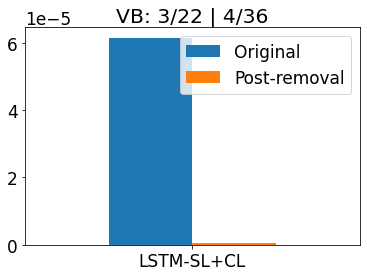

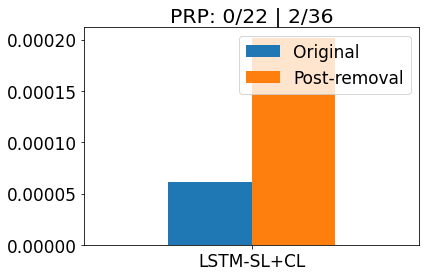

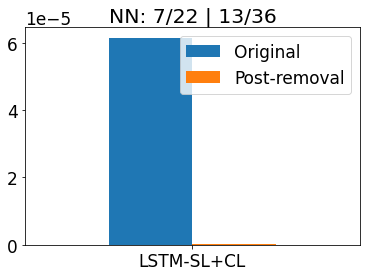

In [59]:
pos_logits_processor(234, pos_categories)

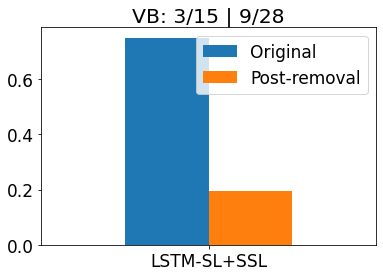

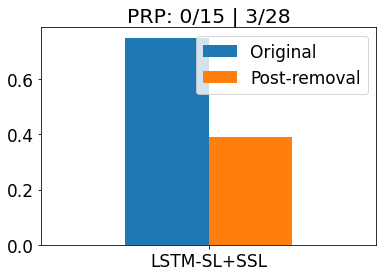

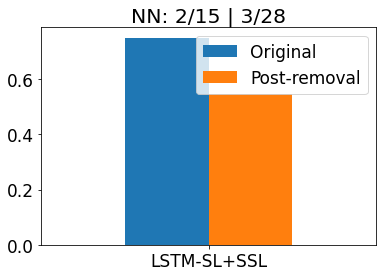

In [56]:
pos_logits_processor(86, pos_categories)

# Confusion Matrix Analysis

In [60]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

model = model.to(torch.device("cpu"))
model2 = model2.to(torch.device("cpu"))

def get_confusion_matrix(network, test_data_loader):
    prediction = []
    actual = []

    # iterate over test data
    for i, batch in enumerate(test_data_loader):
        q1, q2, labels = batch
        q1, q2, labels = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), labels.to(torch.device("cpu")).view(-1)

        output = network(q1, q2)
        output = torch.sigmoid(output).view(-1) > 0.5
        output = output.detach().numpy().tolist()
        prediction.extend(output)

        labels = labels.tolist()
        actual.extend(labels)

    # labels = list(set(actual))
    # labels.sort()

    cf_matrix = confusion_matrix(actual, prediction)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot()
    plt.show()

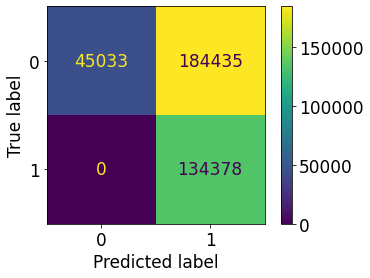

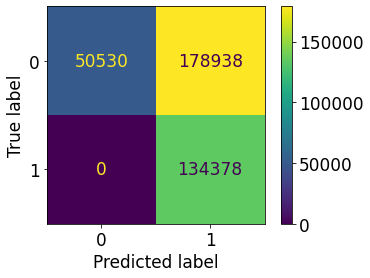

In [61]:
get_confusion_matrix(model, train_loader)
get_confusion_matrix(model2, train_loader)

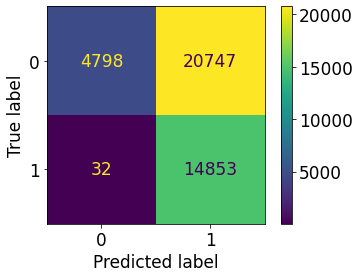

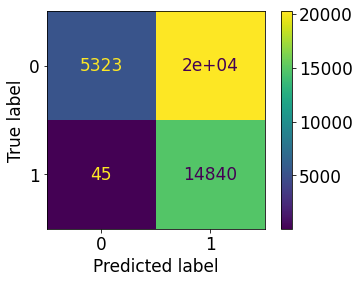

In [62]:
get_confusion_matrix(model, val_loader)
get_confusion_matrix(model2, val_loader)